# Import Libraries


In [325]:
import numpy as np
import pandas as pd

from numpy.lib import stride_tricks

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import itertools
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, LabelBinarizer, StandardScaler, RobustScaler, scale
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import *

from keras.models import Sequential #Sequential Models
from keras.layers import Dense, Dropout, Conv1D, Input, Lambda, Flatten #Dense Fully Connected Layer Type
from keras.optimizers import SGD, Adam #Stochastic Gradient Descent Optimizer
from keras import backend as K

## Data Reading and Exploration

In [326]:
## Reading data.
df = pd.read_csv("../input/NQ_daily.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)
df.drop(["Time"], axis=1, inplace=True)
df.head(10)

,Open,High,Low,Close,Volume,MACD,MACDAvg,MACDDiff,RSI,SlowK,SlowD,FastAvg,SlowAvg,DistF,DistS,FGS,FLS,OpenBar
Date,,,,,,,,,,,,,,,,,,
1999-09-02,2975.0,2978.0,2923.5,2961.5,3404,-1.116809,-0.223362,-0.893447,68.40,72.06,74.92,2964.65,2896.80,3.15,64.70,2,0,1
1999-09-03,2965.0,3074.5,2957.5,3074.0,2633,6.995284,1.220367,5.774917,75.17,79.61,76.01,2982.95,2902.69,91.05,171.31,3,0,1
1999-09-07,3109.5,3109.5,3058.5,3062.5,3398,12.353815,3.447057,8.906758,73.44,81.91,77.86,2993.10,2908.42,69.40,154.08,4,0,1
1999-09-08,3055.5,3067.0,3017.0,3028.5,18,13.699060,5.497458,8.201602,68.42,83.13,81.55,2998.15,2912.49,30.35,116.01,5,0,1
1999-09-09,3003.0,3069.0,3003.0,3065.5,2263,17.548479,7.907662,9.640817,70.76,78.41,81.15,3001.50,2916.69,64.00,148.81,6,0,1
1999-09-10,3069.0,3116.0,3056.0,3096.5,3070,22.837357,10.893601,11.943756,72.60,81.00,80.84,3012.10,2920.85,84.40,175.65,7,0,1
1999-09-13,3108.5,3108.5,3049.0,3059.5,3680,23.769244,13.468729,10.300514,67.18,83.26,80.89,3021.30,2923.90,38.20,135.60,8,0,1
1999-09-14,3060.0,3092.0,3040.5,3075.0,4505,25.464947,15.867973,9.596974,68.25,82.63,82.30,3035.30,2926.64,39.70,148.36,9,0,1
1999-09-15,3075.0,3110.5,3022.0,3025.0,5095,22.514686,17.197316,5.317371,61.31,71.70,79.20,3042.35,2928.59,17.35,96.41,10,0,1


# Calculate Frame Size
Frame Size (input size) for WaveNet models must follow the following equation $$Frame Size = Filter Width * Duplicatiin Multiplier ^{Number of Layers + 1}$$

In [327]:
def calculate_frame_size(dilation_multiplier, dilation_num, filter_width):
    frame_size = (dilation_multiplier**(dilation_num-1)) * filter_width
    return frame_size

# Create Loss Function
Keras does not include a weighted categorical crossentropy loss function.

A weighted version of keras.objectives.categorical_crossentropy
Variables:
- weights: numpy array of shape (C,) where C is the number of classes


In [328]:
def weighted_categorical_crossentropy(weights):

    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

# Normalize Data

There are 3 types of scaling used.

1.	Dividing by 100 for certain values (example: RSI)
2.	Scaling to the first open price of the window. For all price dependent values (example: open, close, high, low, MACD)
3.	Other variables that are not price dependent and are not constant are scaled to the max value of the window (example: the day)


In [329]:
def create_frames(df, frame_size, self_scale_variables, one_scale_variables, output_col):
    """
    Create a frames from a dataframe. 
    
    Variables:
        df:                                  dataframe for the stock.
        frame_size:                          number of time steps to take per frame.
        self_scale_variables:                List of columns to scale to the first one in the frame.
        one_scale_variables:                 Scale to 100 variables.
        output_col:                          Output column.
    """
    frames = list()
    output = list()
    dates = list()
    
    all_features = self_scale_variables + one_scale_variables
    
    for i in range(0, len(df) - frame_size):
        frame_df = df.iloc[i:i+frame_size].copy()
        
        scale_value = frame_df[self_scale_variables[0]].max()
        
        
        if np.abs(scale_value) < np.finfo(np.float32).eps:
            print("## Cannot divide with zero. {} for day: {}".format(scale_value, df.index[i]))
            continue
        
        frame_df[self_scale_variables] = frame_df[self_scale_variables] / scale_value
        frame_df[one_scale_variables] = frame_df[one_scale_variables] / 100.0
        #frame_df[general_scale_variables] = scale(frame_df[general_scale_variables].astype(np.float))
        
        frames.append(frame_df[all_features].values)
        output.append(frame_df[output_col].iloc[-1])
        dates.append(frame_df.index[-1])
    
    return np.array(frames), np.expand_dims(np.array(output), axis=1), dates


# Create Model

Implementation of Wavenet model.
    
    Variables:
        num_features          Number of features per step.
        n_filters:            Number of filters used in the model.
        filter_width:         Number of nodes to include per filter.
        dilation_multiplier:  Skip multiplier for the model.
        dilation_num:         Wavenet convolution height.
        num_outputs:          Number of outputs
        weights:              Weights per class. As weights = np.array([0.5,2,10]) # Class one at 0.5, 
                              class 2 twice the normal weights, class 3 10x.
        learning_rate:        Learning rate for the optimizer
        num_nodes_dense:      Number of nodes in the dense output.
        dropout_rate:         Rate used in dropouts
        output_activation:    Activation function used in the output node.
    

In [330]:

def create_model(num_features, n_filters, filter_width, 
                 dilation_multiplier, dilation_num, 
                 num_outputs, weights, learning_rate,
                 num_nodes_dense, dropout_rate, output_activation):

    
    model = Sequential()
    dilation_rates = [dilation_multiplier**i for i in range(dilation_num)] 
    
    
    frame_size = (dilation_multiplier**(dilation_num-1)) * filter_width
    
    #model.add(Input(shape=(None, 1)))
    
    first_inp = True
    
    for dilation_rate in dilation_rates:
        if first_inp:
            model.add(Conv1D(input_shape=(frame_size, num_features),
                             filters=n_filters,
                             kernel_size=filter_width, 
                             padding='valid',
                             dilation_rate=dilation_rate))
            first_inp = False
        else:
            model.add(Conv1D(filters=n_filters,
                             kernel_size=filter_width, 
                             padding='valid',
                             dilation_rate=dilation_rate))
        
    #model.add(Flatten())
    #model.add(Dense(num_outputs, activation=output_activation))
    
    model.add(Flatten())
    #model.add(Dropout(dropout_rate))
    model.add(Dense(num_outputs, activation=output_activation))
    
    

    if weights is None:
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    else:
        model.compile(loss=weighted_categorical_crossentropy(weights), optimizer=opt, metrics=['accuracy'])
    
    return model, frame_size


# Plot Confusion Matrix

In [331]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Scale Data
We scale the data relative to the previous change value. Later on we well standardize the data as well before training.

In [332]:
## Gobal Definitions.
self_scale_variables = ['Close']
one_scale_variables = ['RSI']

DILATION_MULTIPLIER = 2
DILATION_NUM = 5
FILTER_WIDTH = 2
NEUTRAL_PECT = 0.3

fz = calculate_frame_size(DILATION_MULTIPLIER, DILATION_NUM, FILTER_WIDTH)

print("## Frame Size = {:d}".format(int(fz)))

df["Close_pct"] = df["Close"].pct_change()
df.dropna(inplace=True)

## Frame Size = 32


# Change Labels

We need to create the change type prediction model to create change labels. We use pandas cut function to do this.

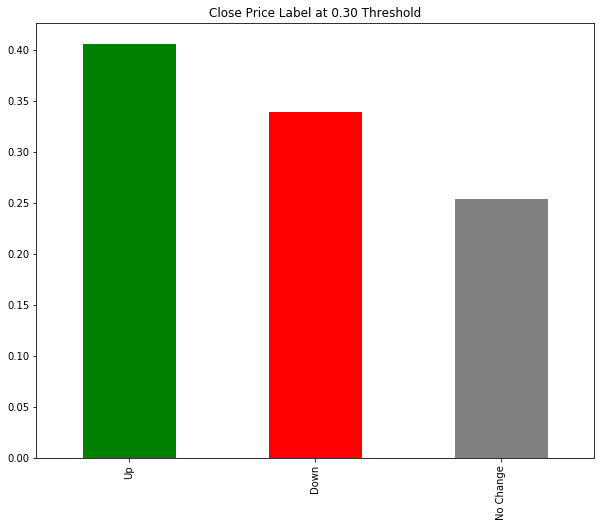

In [333]:
neutral_change = NEUTRAL_PECT / 100.0

bin_edges = [-np.inf, -neutral_change, neutral_change,  np.inf]
labels = ["Down", "No Change", "Up"]
#label_map = [-1.0, 0.0, 1.0]
label_map = [0.0, 1.0, 2.0]

df["Close_label"] = pd.cut(df["Close_pct"], bin_edges , labels=labels, include_lowest=True)
plt.rcParams["figure.figsize"] = (10,8)

change_stats = df["Close_label"].value_counts()
change_stats /= change_stats.sum()
change_stats[["Up", "Down", "No Change"]].plot(kind="bar", title="Close Price Label at {:.2f} Threshold".format(NEUTRAL_PECT), color=["green", "red", "grey"])
plt.show()

# Preparing Data For Training
This model want to predict one day change direction. We assume that we are running prediction 1 day before the day we are trying to predict. Meaning, we don't know today's info like: "Open", "High", etc... Basically, we need to shift the data to get the target close percentage.

Another thing, we need to take into account the day of the week, and other date related info, like month, year, etc..

In [334]:
## Creating date related indicators
df["dow"] = df.index.dayofweek
df["week"] = df.index.week
df["month"] = df.index.month
df["quarter"] = df.index.quarter

## Shifting the close_percentage one day.
df["Close_pct_next_day"] = df["Close_pct"].shift(-1)
df["Close_label_next_day"] = df["Close_label"].shift(-1)

df.dropna(inplace=True)

display(df[["Close_pct", "Close_label", "Close_pct_next_day", "Close_label_next_day"]])

,Close_pct,Close_label,Close_pct_next_day,Close_label_next_day
Date,,,,
1999-09-03,0.037988,Up,-0.003741,Down
1999-09-07,-0.003741,Down,-0.011102,Down
1999-09-08,-0.011102,Down,0.012217,Up
1999-09-09,0.012217,Up,0.010113,Up
1999-09-10,0.010113,Up,-0.011949,Down
1999-09-13,-0.011949,Down,0.005066,Up
1999-09-14,0.005066,Up,-0.016260,Down
1999-09-15,-0.016260,Down,-0.015041,Down
1999-09-16,-0.015041,Down,0.041786,Up


# Wavenet Model

# Normalize Data

In [335]:
date_features = []
## Prepare output
output_col = "label_output"
df[output_col] = df["Close_label_next_day"].apply(lambda x: label_map[labels.index(x)])
df[output_col] = df[output_col].astype(np.int)

## Convert the time series to frames
print("## Frame Size = {}".format(fz))
print("## Number of points = {}".format(len(df)))

X, Y , dates = create_frames(df,fz, self_scale_variables, one_scale_variables, output_col)

x_has_nan = np.isnan(X).any()
y_has_nan = np.isnan(Y).any()

print(x_has_nan)
print(y_has_nan)

print(X.shape)
print(Y.shape)

## Frame Size = 32
## Number of points = 4626
False
False
(4594, 32, 2)
(4594, 1)


# Split The Data

For backtesting purposes, we split the data so that we are attempting to predict that last 400 days of each of the two periods.

The periods used for testing are removed the the training data:

- Period 1: 18th Jan 2007 - 30th October 2008
- Period 2: 11th March 2016 - 29th December 2017


In [336]:
testing_period_1_start = pd.Timestamp(2007, 1, 18)
testing_period_1_end = pd.Timestamp(2008, 10, 30)

testing_period_2_start = pd.Timestamp(2016, 3, 11)
testing_period_2_end = pd.Timestamp(2017, 12, 29)

testing_period_1_start_ind = dates.index(testing_period_1_start)
testing_period_1_end_ind = dates.index(testing_period_1_end)

testing_period_2_start_ind = dates.index(testing_period_2_start)
testing_period_2_end_ind = dates.index(testing_period_2_end)

X_testing_1 = X[testing_period_1_start_ind:testing_period_1_end_ind,:,:]
Y_testing_1 = Y[testing_period_1_start_ind:testing_period_1_end_ind,:]

X_testing_2 = X[testing_period_2_start_ind:testing_period_2_end_ind,:,:]
Y_testing_2 = Y[testing_period_2_start_ind:testing_period_2_end_ind,:]

print(X_testing_1.shape)
print(Y_testing_1.shape)

print(X_testing_2.shape)
print(Y_testing_2.shape)

print("## Total data counts")
#vc = np.apply_along_axis(np.bincount, 1, Y_train)
vc = np.bincount(Y.flatten().astype(np.int))
print(vc / vc.sum())

frames_delete = list(range(testing_period_1_start_ind,testing_period_1_end_ind)) + \
                list(range(testing_period_2_start_ind,testing_period_2_end_ind))
    
X_train = np.delete(X, frames_delete , 0)
Y_train = np.delete(Y, frames_delete , 0)

print(np.isnan(X_train).any())
print(np.isnan(Y_train).any())

print("## Traing data counts.")
#vc = np.apply_along_axis(np.bincount, 1, Y_train)
vc = np.bincount(Y_train.flatten().astype(np.int))
print(vc / vc.sum())

print(X_train.shape)
print(Y_train.shape)


(455, 32, 2)
(455, 1)
(455, 32, 2)
(455, 1)
## Total data counts
[0.33913801 0.25489769 0.4059643 ]
False
False
## Traing data counts.
[0.34826276 0.23751357 0.41422367]
(3684, 32, 2)
(3684, 1)


In [337]:
## Split data
train_valid_ratio = 0.3
enable_testing = False

## FOR TESTING ONLY NEED TO BE REMOVED
if enable_testing:
    max_samples = 200
    frames = frames[:max_samples,:,:]
    Y_arr = Y_arr[:max_samples, :]
    print(frames.shape)
    print(Y_arr.shape)
## FOR TESTING ONLY NEED TO BE REMOVED

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=train_valid_ratio)

print(X_train.shape)
print(Y_train.shape)

print(X_valid.shape)
print(Y_valid.shape)

## Validating the distribution of the output column.

print("## Training data counts.")
#vc = np.apply_along_axis(np.bincount, 1, Y_train)
vc = np.bincount(Y_train.flatten().astype(np.int))
print(vc / vc.sum())

print("## Validation data counts.")
#vc = np.apply_along_axis(np.bincount, 1, Y_valid)
vc = np.bincount(Y_valid.flatten().astype(np.int))
print(vc / vc.sum())

(2578, 32, 2)
(2578, 1)
(1106, 32, 2)
(1106, 1)
## Training data counts.
[0.34251358 0.24592708 0.41155935]
## Validation data counts.
[0.36166365 0.21790235 0.420434  ]


In [338]:
encoder = LabelBinarizer()

Y_train = encoder.fit_transform(Y_train)
Y_valid = encoder.transform(Y_valid)

# Y_train = np.expand_dims(Y_train, axis=1)
# Y_valid = np.expand_dims(Y_valid, axis=1)
# Y_test  = np.expand_dims(Y_test, axis=1)

print(Y_train.shape)
print(Y_valid.shape)

Y_testing_1 = encoder.transform(Y_testing_1)
Y_testing_2 = encoder.transform(Y_testing_2)

Y_test = np.concatenate([Y_testing_1, Y_testing_2], axis=0)
X_test = np.concatenate([X_testing_1, X_testing_2], axis=0)

print(Y_testing_1.shape)
print(Y_testing_2.shape)
print(Y_test.shape)

print(X_test.shape)

(2578, 3)
(1106, 3)
(455, 3)
(455, 3)
(910, 3)
(910, 32, 2)


In [339]:
feature_list = self_scale_variables + one_scale_variables + date_features

def run_training_iteration(model_params):
    class_weights = None

    print("## Class weights : {}".format(class_weights))

    wavenet, fz = create_model(**model_params)
    
    print(fz)
    wavenet.summary()
    
    ## Training the model
    history = wavenet.fit(X_train, Y_train, 
                      epochs=1000, batch_size=480,
                      validation_data=(X_valid, Y_valid))
    
    plt.rcParams["figure.figsize"] = (16,12)

    #  "Accuracy"
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.grid()
    plt.show()

    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.grid()
    plt.show()

    prediction = np.reshape(wavenet.predict(X_test), (len(X_test), len(encoder.classes_)))
    pred = np.argmax(prediction, axis=1)
    Y_test_res = np.argmax(np.reshape(Y_test, (len(X_test), len(encoder.classes_))) , axis=1)

    #print(prediction.shape)
    #print(pred.shape)
    #print(Y_test_res.shape)

    #print(prediction)
    #print(pred)
    #print(Y_test_res)

    error_rate = np.sum(pred == Y_test_res) / Y_test_res.shape[0]

    print("## Wavenet model accuracy: {}".format(error_rate * 100.0))

    cnf_matrix = confusion_matrix(Y_test_res, pred)
    plot_confusion_matrix(cnf_matrix, classes=labels, 
                          normalize=True, title='Wavenet Model Normalized confusion matrix')
    return wavenet

# Train Model

## Class weights : None
32
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_85 (Conv1D)           (None, 31, 16)            80        
_________________________________________________________________
conv1d_86 (Conv1D)           (None, 29, 16)            528       
_________________________________________________________________
conv1d_87 (Conv1D)           (None, 25, 16)            528       
_________________________________________________________________
conv1d_88 (Conv1D)           (None, 17, 16)            528       
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 1, 16)             528       
_________________________________________________________________
flatten_19 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 3)           

Epoch 51/1000
2578/2578 [==============================] - 0s 31us/step - loss: 1.0628 - acc: 0.4092 - val_loss: 1.0538 - val_acc: 0.4222
Epoch 52/1000
2578/2578 [==============================] - 0s 28us/step - loss: 1.0628 - acc: 0.4092 - val_loss: 1.0570 - val_acc: 0.4250
Epoch 53/1000
2578/2578 [==============================] - 0s 32us/step - loss: 1.0635 - acc: 0.4213 - val_loss: 1.0537 - val_acc: 0.4222
Epoch 54/1000
2578/2578 [==============================] - 0s 31us/step - loss: 1.0628 - acc: 0.4081 - val_loss: 1.0531 - val_acc: 0.4213
Epoch 55/1000
2578/2578 [==============================] - 0s 30us/step - loss: 1.0623 - acc: 0.4085 - val_loss: 1.0559 - val_acc: 0.4277
Epoch 56/1000
2578/2578 [==============================] - 0s 29us/step - loss: 1.0623 - acc: 0.4119 - val_loss: 1.0536 - val_acc: 0.4231
Epoch 57/1000
2578/2578 [==============================] - 0s 28us/step - loss: 1.0635 - acc: 0.4154 - val_loss: 1.0526 - val_acc: 0.4195
Epoch 58/1000
2578/2578 [=========

2578/2578 [==============================] - 0s 31us/step - loss: 1.0577 - acc: 0.4216 - val_loss: 1.0527 - val_acc: 0.4268
Epoch 111/1000
2578/2578 [==============================] - 0s 31us/step - loss: 1.0575 - acc: 0.4193 - val_loss: 1.0520 - val_acc: 0.4277
Epoch 112/1000
2578/2578 [==============================] - 0s 28us/step - loss: 1.0575 - acc: 0.4119 - val_loss: 1.0521 - val_acc: 0.4259
Epoch 113/1000
2578/2578 [==============================] - 0s 29us/step - loss: 1.0575 - acc: 0.4193 - val_loss: 1.0501 - val_acc: 0.4268
Epoch 114/1000
2578/2578 [==============================] - 0s 29us/step - loss: 1.0577 - acc: 0.4147 - val_loss: 1.0519 - val_acc: 0.4295
Epoch 115/1000
2578/2578 [==============================] - 0s 29us/step - loss: 1.0568 - acc: 0.4205 - val_loss: 1.0502 - val_acc: 0.4286
Epoch 116/1000
2578/2578 [==============================] - 0s 29us/step - loss: 1.0566 - acc: 0.4139 - val_loss: 1.0517 - val_acc: 0.4304
Epoch 117/1000
2578/2578 [================

2578/2578 [==============================] - 0s 46us/step - loss: 1.0498 - acc: 0.4209 - val_loss: 1.0570 - val_acc: 0.4042
Epoch 170/1000
2578/2578 [==============================] - 0s 50us/step - loss: 1.0517 - acc: 0.4259 - val_loss: 1.0462 - val_acc: 0.4268
Epoch 171/1000
2578/2578 [==============================] - 0s 58us/step - loss: 1.0485 - acc: 0.4216 - val_loss: 1.0526 - val_acc: 0.4186
Epoch 172/1000
2578/2578 [==============================] - 0s 47us/step - loss: 1.0501 - acc: 0.4216 - val_loss: 1.0522 - val_acc: 0.4150
Epoch 173/1000
2578/2578 [==============================] - 0s 55us/step - loss: 1.0500 - acc: 0.4220 - val_loss: 1.0468 - val_acc: 0.4259
Epoch 174/1000
2578/2578 [==============================] - 0s 37us/step - loss: 1.0494 - acc: 0.4279 - val_loss: 1.0458 - val_acc: 0.4385
Epoch 175/1000
2578/2578 [==============================] - 0s 36us/step - loss: 1.0496 - acc: 0.4232 - val_loss: 1.0595 - val_acc: 0.4069
Epoch 176/1000
2578/2578 [================

2578/2578 [==============================] - 0s 30us/step - loss: 1.0450 - acc: 0.4290 - val_loss: 1.0569 - val_acc: 0.4051
Epoch 229/1000
2578/2578 [==============================] - 0s 31us/step - loss: 1.0430 - acc: 0.4360 - val_loss: 1.0495 - val_acc: 0.4195
Epoch 230/1000
2578/2578 [==============================] - 0s 29us/step - loss: 1.0414 - acc: 0.4352 - val_loss: 1.0486 - val_acc: 0.4168
Epoch 231/1000
2578/2578 [==============================] - 0s 29us/step - loss: 1.0471 - acc: 0.4193 - val_loss: 1.0507 - val_acc: 0.4222
Epoch 232/1000
2578/2578 [==============================] - 0s 28us/step - loss: 1.0457 - acc: 0.4286 - val_loss: 1.0655 - val_acc: 0.4014
Epoch 233/1000
2578/2578 [==============================] - 0s 29us/step - loss: 1.0425 - acc: 0.4360 - val_loss: 1.0443 - val_acc: 0.4204
Epoch 234/1000
2578/2578 [==============================] - 0s 28us/step - loss: 1.0439 - acc: 0.4306 - val_loss: 1.0469 - val_acc: 0.4204
Epoch 235/1000
2578/2578 [================

2578/2578 [==============================] - 0s 31us/step - loss: 1.0406 - acc: 0.4325 - val_loss: 1.0458 - val_acc: 0.4213
Epoch 288/1000
2578/2578 [==============================] - 0s 39us/step - loss: 1.0406 - acc: 0.4352 - val_loss: 1.0462 - val_acc: 0.4213
Epoch 289/1000
2578/2578 [==============================] - 0s 54us/step - loss: 1.0390 - acc: 0.4372 - val_loss: 1.0542 - val_acc: 0.4105
Epoch 290/1000
2578/2578 [==============================] - 0s 42us/step - loss: 1.0385 - acc: 0.4286 - val_loss: 1.0451 - val_acc: 0.4213
Epoch 291/1000
2578/2578 [==============================] - 0s 37us/step - loss: 1.0410 - acc: 0.4368 - val_loss: 1.0492 - val_acc: 0.4141
Epoch 292/1000
2578/2578 [==============================] - 0s 38us/step - loss: 1.0380 - acc: 0.4344 - val_loss: 1.0473 - val_acc: 0.4141
Epoch 293/1000
2578/2578 [==============================] - 0s 41us/step - loss: 1.0405 - acc: 0.4329 - val_loss: 1.0451 - val_acc: 0.4204
Epoch 294/1000
2578/2578 [================

2578/2578 [==============================] - 0s 36us/step - loss: 1.0368 - acc: 0.4294 - val_loss: 1.0457 - val_acc: 0.4114
Epoch 347/1000
2578/2578 [==============================] - 0s 37us/step - loss: 1.0377 - acc: 0.4360 - val_loss: 1.0647 - val_acc: 0.3987
Epoch 348/1000
2578/2578 [==============================] - 0s 31us/step - loss: 1.0414 - acc: 0.4236 - val_loss: 1.0553 - val_acc: 0.4195
Epoch 349/1000
2578/2578 [==============================] - 0s 37us/step - loss: 1.0514 - acc: 0.4290 - val_loss: 1.0506 - val_acc: 0.4105
Epoch 350/1000
2578/2578 [==============================] - 0s 46us/step - loss: 1.0390 - acc: 0.4360 - val_loss: 1.0462 - val_acc: 0.4177
Epoch 351/1000
2578/2578 [==============================] - 0s 34us/step - loss: 1.0392 - acc: 0.4306 - val_loss: 1.0453 - val_acc: 0.4304
Epoch 352/1000
2578/2578 [==============================] - 0s 33us/step - loss: 1.0417 - acc: 0.4298 - val_loss: 1.0554 - val_acc: 0.4014
Epoch 353/1000
2578/2578 [================

2578/2578 [==============================] - 0s 35us/step - loss: 1.0470 - acc: 0.4263 - val_loss: 1.0456 - val_acc: 0.4259
Epoch 406/1000
2578/2578 [==============================] - 0s 32us/step - loss: 1.0478 - acc: 0.4271 - val_loss: 1.0512 - val_acc: 0.4141
Epoch 407/1000
2578/2578 [==============================] - 0s 32us/step - loss: 1.0419 - acc: 0.4333 - val_loss: 1.0484 - val_acc: 0.4123
Epoch 408/1000
2578/2578 [==============================] - 0s 32us/step - loss: 1.0383 - acc: 0.4279 - val_loss: 1.0470 - val_acc: 0.4168
Epoch 409/1000
2578/2578 [==============================] - 0s 32us/step - loss: 1.0365 - acc: 0.4368 - val_loss: 1.0532 - val_acc: 0.4123
Epoch 410/1000
2578/2578 [==============================] - 0s 31us/step - loss: 1.0385 - acc: 0.4275 - val_loss: 1.0467 - val_acc: 0.4231
Epoch 411/1000
2578/2578 [==============================] - 0s 32us/step - loss: 1.0382 - acc: 0.4310 - val_loss: 1.0517 - val_acc: 0.4024
Epoch 412/1000
2578/2578 [================

2578/2578 [==============================] - 0s 30us/step - loss: 1.0380 - acc: 0.4294 - val_loss: 1.0616 - val_acc: 0.3924
Epoch 465/1000
2578/2578 [==============================] - 0s 31us/step - loss: 1.0375 - acc: 0.4313 - val_loss: 1.0460 - val_acc: 0.4159
Epoch 466/1000
2578/2578 [==============================] - 0s 29us/step - loss: 1.0344 - acc: 0.4348 - val_loss: 1.0582 - val_acc: 0.4087
Epoch 467/1000
2578/2578 [==============================] - 0s 30us/step - loss: 1.0347 - acc: 0.4255 - val_loss: 1.0476 - val_acc: 0.4204
Epoch 468/1000
2578/2578 [==============================] - 0s 30us/step - loss: 1.0406 - acc: 0.4306 - val_loss: 1.0580 - val_acc: 0.4005
Epoch 469/1000
2578/2578 [==============================] - 0s 29us/step - loss: 1.0356 - acc: 0.4325 - val_loss: 1.0466 - val_acc: 0.4222
Epoch 470/1000
2578/2578 [==============================] - 0s 29us/step - loss: 1.0353 - acc: 0.4395 - val_loss: 1.0475 - val_acc: 0.4177
Epoch 471/1000
2578/2578 [================

2578/2578 [==============================] - 0s 36us/step - loss: 1.0379 - acc: 0.4341 - val_loss: 1.0559 - val_acc: 0.4105
Epoch 524/1000
2578/2578 [==============================] - 0s 34us/step - loss: 1.0358 - acc: 0.4348 - val_loss: 1.0475 - val_acc: 0.4132
Epoch 525/1000
2578/2578 [==============================] - 0s 31us/step - loss: 1.0360 - acc: 0.4313 - val_loss: 1.0455 - val_acc: 0.4159
Epoch 526/1000
2578/2578 [==============================] - 0s 33us/step - loss: 1.0344 - acc: 0.4395 - val_loss: 1.0519 - val_acc: 0.4033
Epoch 527/1000
2578/2578 [==============================] - 0s 31us/step - loss: 1.0361 - acc: 0.4251 - val_loss: 1.0452 - val_acc: 0.4277
Epoch 528/1000
2578/2578 [==============================] - 0s 31us/step - loss: 1.0372 - acc: 0.4325 - val_loss: 1.0583 - val_acc: 0.3978
Epoch 529/1000
2578/2578 [==============================] - 0s 30us/step - loss: 1.0356 - acc: 0.4395 - val_loss: 1.0453 - val_acc: 0.4132
Epoch 530/1000
2578/2578 [================

2578/2578 [==============================] - 0s 35us/step - loss: 1.0332 - acc: 0.4422 - val_loss: 1.0458 - val_acc: 0.4177
Epoch 583/1000
2578/2578 [==============================] - 0s 35us/step - loss: 1.0336 - acc: 0.4465 - val_loss: 1.0536 - val_acc: 0.4150
Epoch 584/1000
2578/2578 [==============================] - 0s 34us/step - loss: 1.0340 - acc: 0.4410 - val_loss: 1.0458 - val_acc: 0.4087
Epoch 585/1000
2578/2578 [==============================] - 0s 30us/step - loss: 1.0329 - acc: 0.4399 - val_loss: 1.0488 - val_acc: 0.4087
Epoch 586/1000
2578/2578 [==============================] - 0s 30us/step - loss: 1.0318 - acc: 0.4360 - val_loss: 1.0457 - val_acc: 0.4150
Epoch 587/1000
2578/2578 [==============================] - 0s 30us/step - loss: 1.0344 - acc: 0.4407 - val_loss: 1.0504 - val_acc: 0.4005
Epoch 588/1000
2578/2578 [==============================] - 0s 30us/step - loss: 1.0326 - acc: 0.4445 - val_loss: 1.0467 - val_acc: 0.4051
Epoch 589/1000
2578/2578 [================

2578/2578 [==============================] - 0s 34us/step - loss: 1.0335 - acc: 0.4310 - val_loss: 1.0485 - val_acc: 0.4250
Epoch 642/1000
2578/2578 [==============================] - 0s 35us/step - loss: 1.0345 - acc: 0.4461 - val_loss: 1.0626 - val_acc: 0.3942
Epoch 643/1000
2578/2578 [==============================] - 0s 34us/step - loss: 1.0379 - acc: 0.4360 - val_loss: 1.0473 - val_acc: 0.4105
Epoch 644/1000
2578/2578 [==============================] - 0s 30us/step - loss: 1.0337 - acc: 0.4348 - val_loss: 1.0512 - val_acc: 0.4069
Epoch 645/1000
2578/2578 [==============================] - 0s 30us/step - loss: 1.0327 - acc: 0.4395 - val_loss: 1.0503 - val_acc: 0.4241
Epoch 646/1000
2578/2578 [==============================] - 0s 31us/step - loss: 1.0332 - acc: 0.4484 - val_loss: 1.0505 - val_acc: 0.4042
Epoch 647/1000
2578/2578 [==============================] - 0s 30us/step - loss: 1.0328 - acc: 0.4476 - val_loss: 1.0492 - val_acc: 0.3960
Epoch 648/1000
2578/2578 [================

2578/2578 [==============================] - 0s 34us/step - loss: 1.0339 - acc: 0.4441 - val_loss: 1.0568 - val_acc: 0.3996
Epoch 701/1000
2578/2578 [==============================] - 0s 37us/step - loss: 1.0337 - acc: 0.4395 - val_loss: 1.0469 - val_acc: 0.4114
Epoch 702/1000
2578/2578 [==============================] - 0s 43us/step - loss: 1.0310 - acc: 0.4426 - val_loss: 1.0506 - val_acc: 0.4024
Epoch 703/1000
2578/2578 [==============================] - 0s 34us/step - loss: 1.0310 - acc: 0.4426 - val_loss: 1.0473 - val_acc: 0.4096
Epoch 704/1000
2578/2578 [==============================] - 0s 31us/step - loss: 1.0319 - acc: 0.4434 - val_loss: 1.0520 - val_acc: 0.3987
Epoch 705/1000
2578/2578 [==============================] - 0s 30us/step - loss: 1.0311 - acc: 0.4348 - val_loss: 1.0466 - val_acc: 0.4060
Epoch 706/1000
2578/2578 [==============================] - 0s 31us/step - loss: 1.0327 - acc: 0.4310 - val_loss: 1.0493 - val_acc: 0.4024
Epoch 707/1000
2578/2578 [================

2578/2578 [==============================] - 0s 32us/step - loss: 1.0310 - acc: 0.4395 - val_loss: 1.0489 - val_acc: 0.4141
Epoch 760/1000
2578/2578 [==============================] - 0s 36us/step - loss: 1.0303 - acc: 0.4391 - val_loss: 1.0494 - val_acc: 0.4087
Epoch 761/1000
2578/2578 [==============================] - 0s 35us/step - loss: 1.0316 - acc: 0.4438 - val_loss: 1.0513 - val_acc: 0.4014
Epoch 762/1000
2578/2578 [==============================] - 0s 31us/step - loss: 1.0311 - acc: 0.4372 - val_loss: 1.0496 - val_acc: 0.4051
Epoch 763/1000
2578/2578 [==============================] - 0s 32us/step - loss: 1.0306 - acc: 0.4387 - val_loss: 1.0481 - val_acc: 0.4141
Epoch 764/1000
2578/2578 [==============================] - 0s 30us/step - loss: 1.0329 - acc: 0.4418 - val_loss: 1.0573 - val_acc: 0.3951
Epoch 765/1000
2578/2578 [==============================] - 0s 30us/step - loss: 1.0324 - acc: 0.4395 - val_loss: 1.0479 - val_acc: 0.4060
Epoch 766/1000
2578/2578 [================

2578/2578 [==============================] - 0s 30us/step - loss: 1.0322 - acc: 0.4449 - val_loss: 1.0535 - val_acc: 0.4186
Epoch 819/1000
2578/2578 [==============================] - 0s 32us/step - loss: 1.0310 - acc: 0.4426 - val_loss: 1.0506 - val_acc: 0.4042
Epoch 820/1000
2578/2578 [==============================] - 0s 30us/step - loss: 1.0300 - acc: 0.4418 - val_loss: 1.0488 - val_acc: 0.4051
Epoch 821/1000
2578/2578 [==============================] - 0s 28us/step - loss: 1.0315 - acc: 0.4457 - val_loss: 1.0514 - val_acc: 0.3933
Epoch 822/1000
2578/2578 [==============================] - 0s 29us/step - loss: 1.0306 - acc: 0.4348 - val_loss: 1.0498 - val_acc: 0.4033
Epoch 823/1000
2578/2578 [==============================] - 0s 28us/step - loss: 1.0300 - acc: 0.4399 - val_loss: 1.0513 - val_acc: 0.4051
Epoch 824/1000
2578/2578 [==============================] - 0s 30us/step - loss: 1.0301 - acc: 0.4414 - val_loss: 1.0505 - val_acc: 0.4078
Epoch 825/1000
2578/2578 [================

2578/2578 [==============================] - 0s 44us/step - loss: 1.0407 - acc: 0.4356 - val_loss: 1.0600 - val_acc: 0.3897
Epoch 878/1000
2578/2578 [==============================] - 0s 40us/step - loss: 1.0385 - acc: 0.4352 - val_loss: 1.0489 - val_acc: 0.4033
Epoch 879/1000
2578/2578 [==============================] - 0s 40us/step - loss: 1.0342 - acc: 0.4372 - val_loss: 1.0513 - val_acc: 0.4014
Epoch 880/1000
2578/2578 [==============================] - 0s 40us/step - loss: 1.0334 - acc: 0.4356 - val_loss: 1.0508 - val_acc: 0.4005
Epoch 881/1000
2578/2578 [==============================] - 0s 39us/step - loss: 1.0327 - acc: 0.4418 - val_loss: 1.0491 - val_acc: 0.4060
Epoch 882/1000
2578/2578 [==============================] - 0s 39us/step - loss: 1.0318 - acc: 0.4441 - val_loss: 1.0544 - val_acc: 0.3816
Epoch 883/1000
2578/2578 [==============================] - 0s 38us/step - loss: 1.0293 - acc: 0.4449 - val_loss: 1.0494 - val_acc: 0.3951
Epoch 884/1000
2578/2578 [================

2578/2578 [==============================] - 0s 42us/step - loss: 1.0281 - acc: 0.4449 - val_loss: 1.0548 - val_acc: 0.3870
Epoch 937/1000
2578/2578 [==============================] - 0s 44us/step - loss: 1.0282 - acc: 0.4503 - val_loss: 1.0503 - val_acc: 0.4024
Epoch 938/1000
2578/2578 [==============================] - 0s 42us/step - loss: 1.0307 - acc: 0.4445 - val_loss: 1.0574 - val_acc: 0.3951
Epoch 939/1000
2578/2578 [==============================] - 0s 53us/step - loss: 1.0317 - acc: 0.4387 - val_loss: 1.0515 - val_acc: 0.3978
Epoch 940/1000
2578/2578 [==============================] - 0s 61us/step - loss: 1.0409 - acc: 0.4375 - val_loss: 1.0612 - val_acc: 0.3843
Epoch 941/1000
2578/2578 [==============================] - 0s 55us/step - loss: 1.0317 - acc: 0.4414 - val_loss: 1.0507 - val_acc: 0.4042
Epoch 942/1000
2578/2578 [==============================] - 0s 49us/step - loss: 1.0296 - acc: 0.4407 - val_loss: 1.0570 - val_acc: 0.3779
Epoch 943/1000
2578/2578 [================

2578/2578 [==============================] - 0s 39us/step - loss: 1.0282 - acc: 0.4430 - val_loss: 1.0523 - val_acc: 0.3996
Epoch 996/1000
2578/2578 [==============================] - 0s 37us/step - loss: 1.0287 - acc: 0.4422 - val_loss: 1.0493 - val_acc: 0.4033
Epoch 997/1000
2578/2578 [==============================] - 0s 36us/step - loss: 1.0293 - acc: 0.4461 - val_loss: 1.0561 - val_acc: 0.3888
Epoch 998/1000
2578/2578 [==============================] - 0s 37us/step - loss: 1.0316 - acc: 0.4426 - val_loss: 1.0516 - val_acc: 0.4033
Epoch 999/1000
2578/2578 [==============================] - 0s 35us/step - loss: 1.0283 - acc: 0.4515 - val_loss: 1.0615 - val_acc: 0.3761
Epoch 1000/1000
2578/2578 [==============================] - 0s 39us/step - loss: 1.0295 - acc: 0.4391 - val_loss: 1.0513 - val_acc: 0.4042


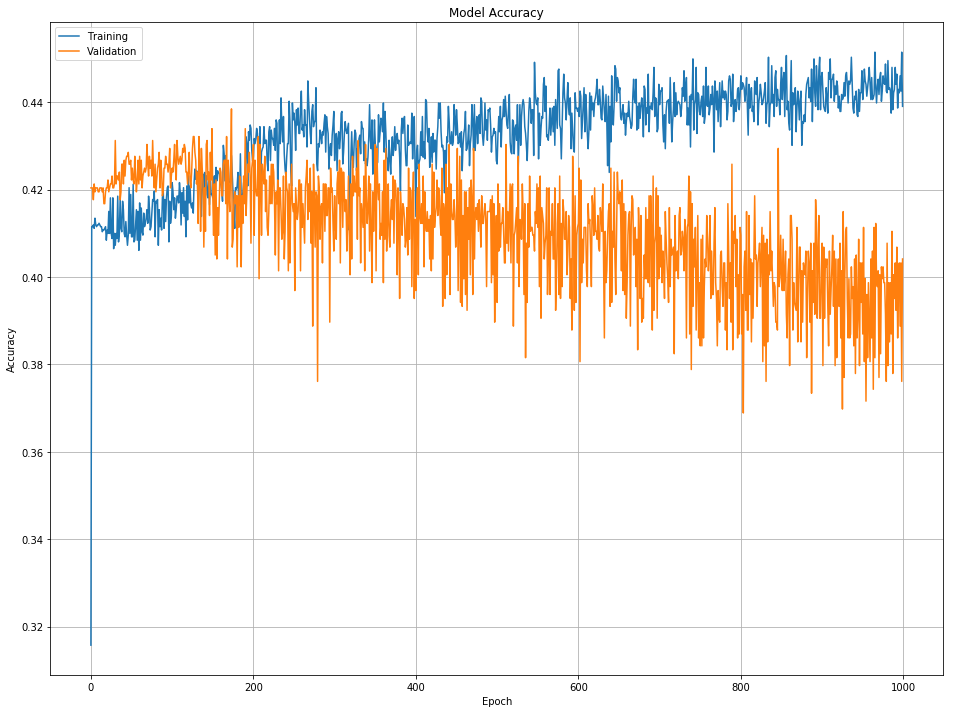

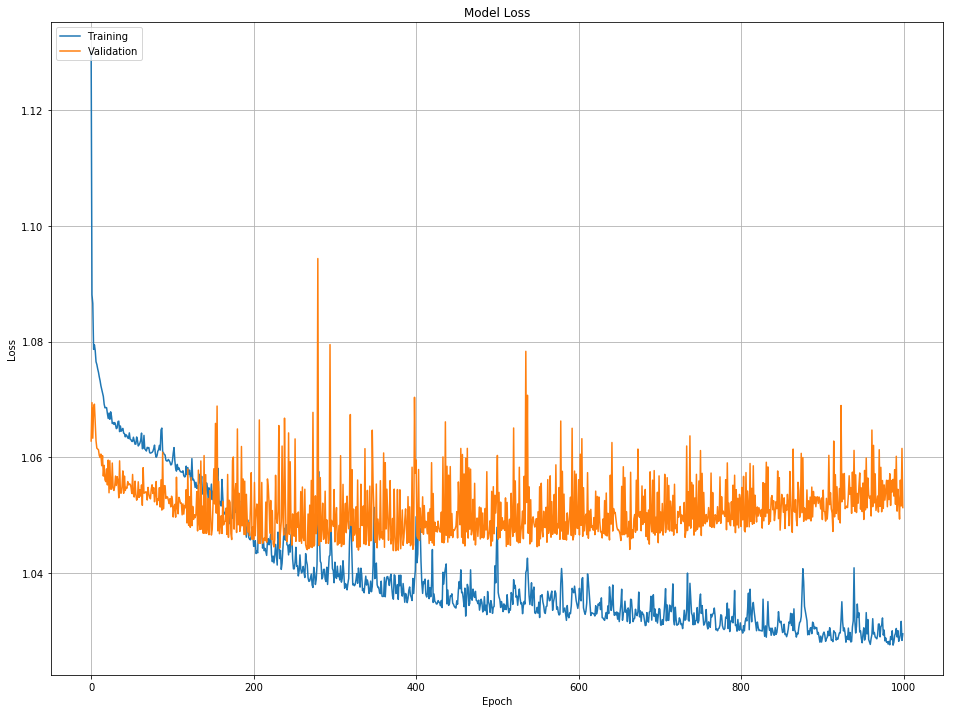

## Wavenet model accuracy: 39.67032967032967
Normalized confusion matrix


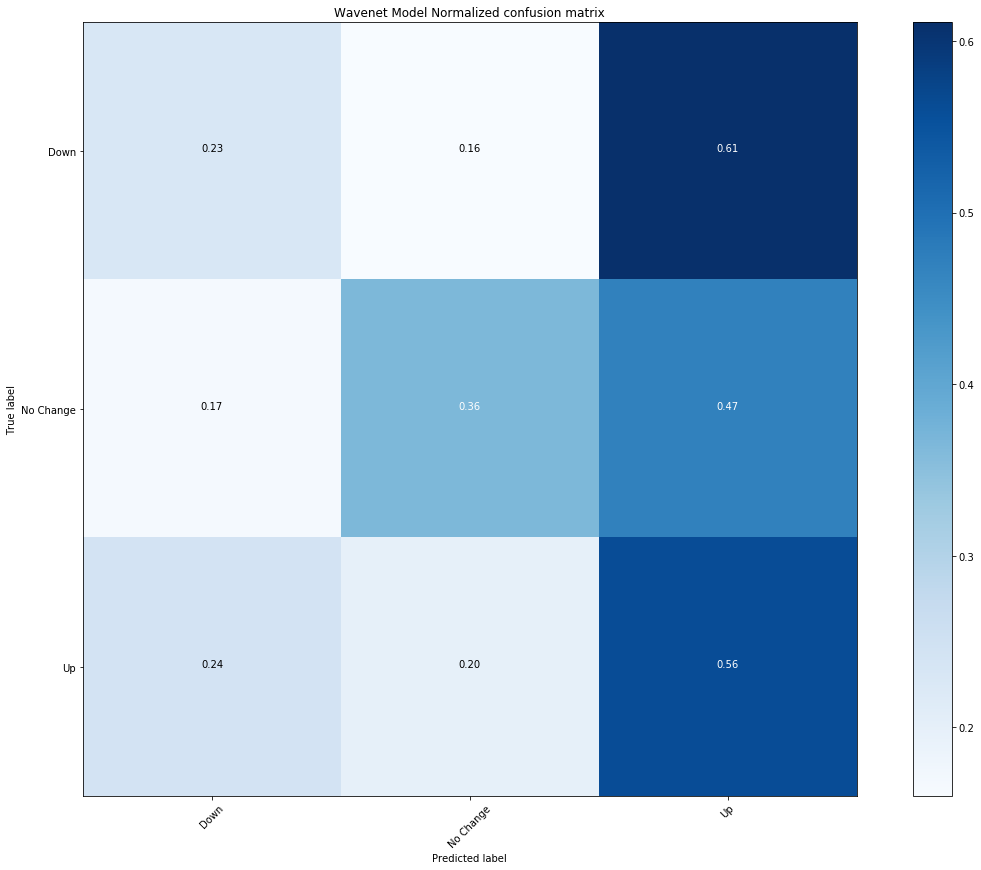

In [340]:
params = {'num_features': len(feature_list), 
          "n_filters": 16, 
          "filter_width": FILTER_WIDTH,
          "dilation_multiplier": DILATION_MULTIPLIER,
          "dilation_num": DILATION_NUM,
          "num_outputs": len(label_map),
          "weights": None,
          "learning_rate": 0.001,
          "num_nodes_dense": 64,
          "dropout_rate": 0.2,
          "output_activation": "softmax"}

model = run_training_iteration(params)

Normalized confusion matrix


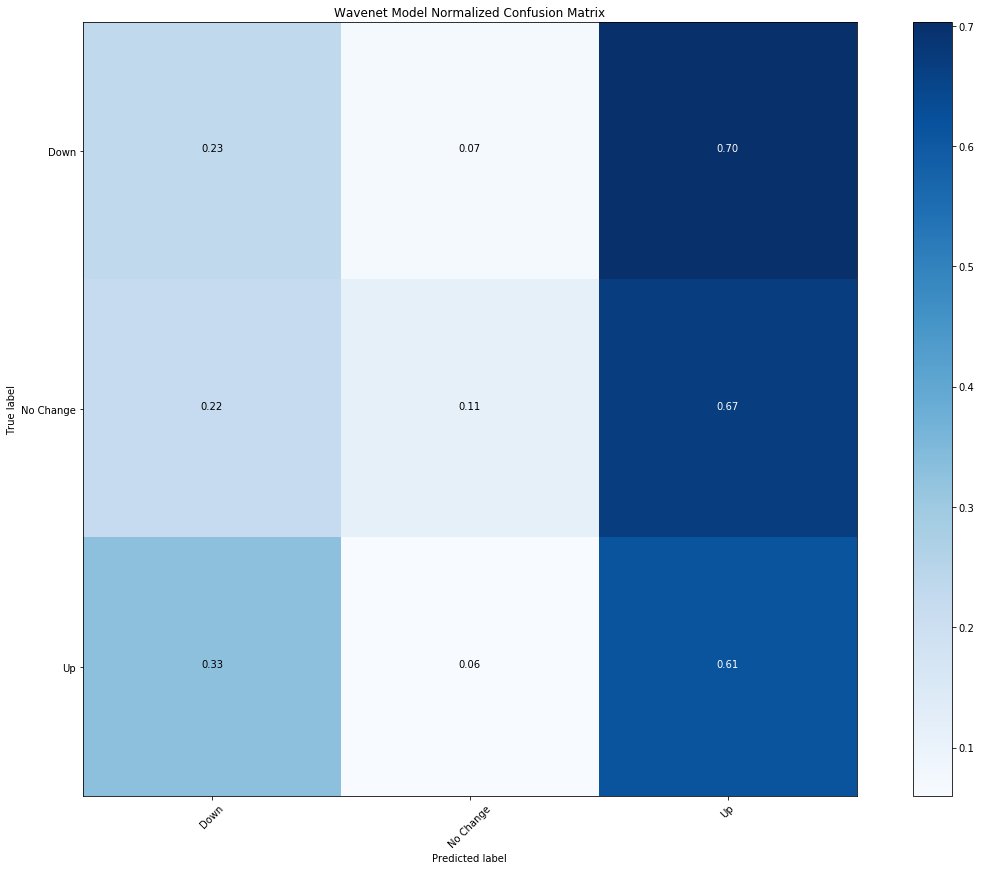

## Wavenet model 1 accuracy: 36.043956043956044


In [341]:
prediction_1 = np.reshape(model.predict(X_testing_1), (len(X_testing_1), len(encoder.classes_)))
pred_1 = np.argmax(prediction_1, axis=1)
Y_test_res_1 = np.argmax(np.reshape(Y_testing_1, (len(X_testing_1), len(encoder.classes_))) , axis=1)

period_1_df = pd.DataFrame({"Date": dates[testing_period_1_start_ind:testing_period_1_end_ind], 
                            "Next_Day_Prediction": [labels[int(i)] for i in pred_1],
                            "Next_Day_Original": [labels[int(i)] for i in Y_test_res_1]})

period_1_df.to_csv("period_1_prediction.csv", index=False)

cnf_matrix = confusion_matrix(Y_test_res_1, pred_1)
plot_confusion_matrix(cnf_matrix, classes=labels, 
                      normalize=True, title='Wavenet Model Normalized Confusion Matrix')

error_rate_1 = np.sum(pred_1 == Y_test_res_1) / Y_test_res_1.shape[0]

print("## Wavenet model 1 accuracy: {}".format(error_rate_1 * 100.0))


Normalized confusion matrix


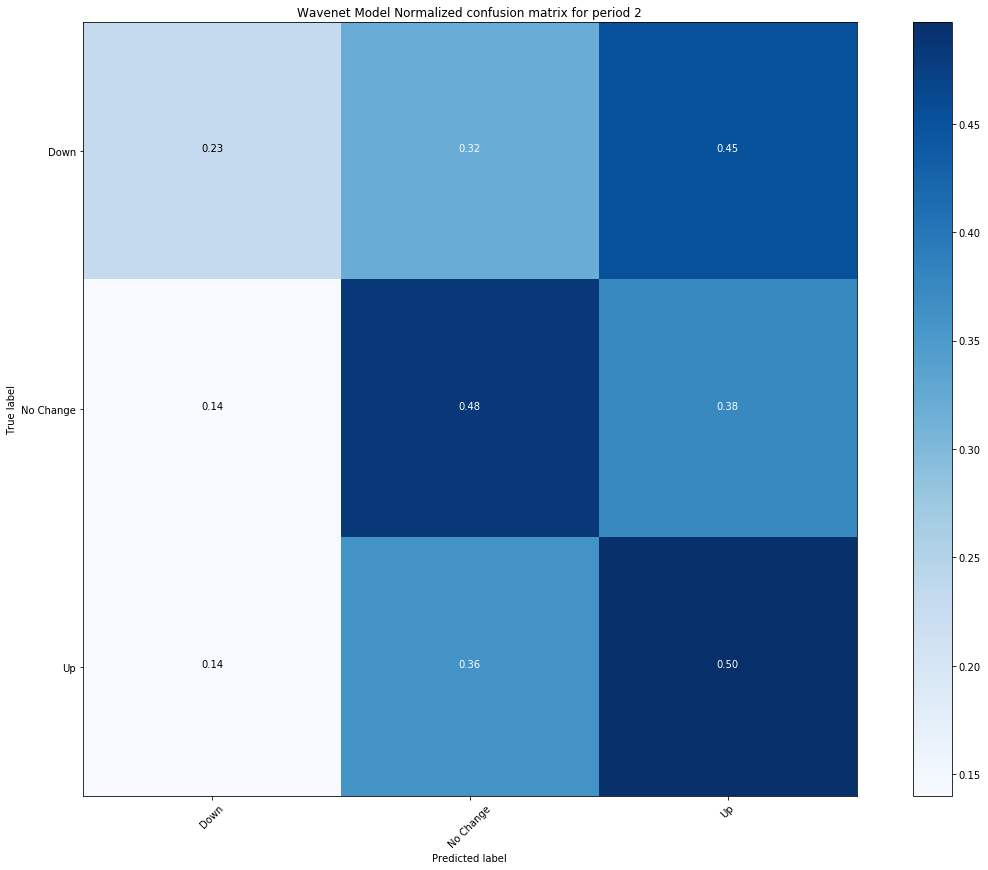

## Wavenet model 1 accuracy: 43.2967032967033


In [342]:
prediction_2 = np.reshape(model.predict(X_testing_2), (len(X_testing_2), len(encoder.classes_)))
pred_2 = np.argmax(prediction_2, axis=1)
Y_test_res_2 = np.argmax(np.reshape(Y_testing_2, (len(X_testing_2), len(encoder.classes_))) , axis=1)

period_2_df = pd.DataFrame({"Date": dates[testing_period_2_start_ind:testing_period_2_end_ind], 
                            "Next_Day_Prediction": [labels[int(i)] for i in pred_2],
                            "Next_Day_Original": [labels[int(i)] for i in Y_test_res_2]})

period_2_df.to_csv("period_2_prediction.csv", index=False)

cnf_matrix = confusion_matrix(Y_test_res_2, pred_2)
plot_confusion_matrix(cnf_matrix, classes=labels, 
                      normalize=True, title='Wavenet Model Normalized confusion matrix for period 2')

error_rate_2 = np.sum(pred_2 == Y_test_res_2) / Y_test_res_2.shape[0]

print("## Wavenet model 1 accuracy: {}".format(error_rate_2 * 100.0))
